In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Embedding
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/sharonedayan/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


The second step of the algorithm is to train a stacked Auto-encoder in order to get the binary mask of the left ventricule inferred shape within the ROI (region of interest output of CNN). It is performed in two steps : pre-training then fine-tuning.

## Open DataSet

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


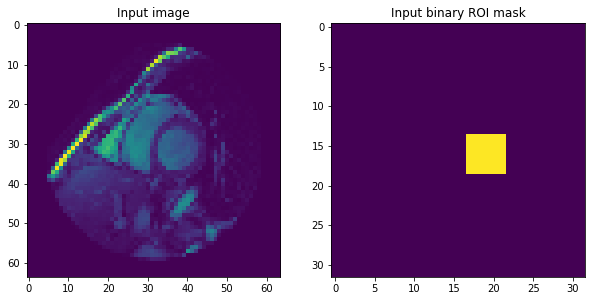

Size for each layer :
Layer, Input Size, Output Size
Conv2D_1 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_1 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_1 (None, 9, 9, 100) (None, 1, 8100)
Dense_1 (None, 1, 8100) (None, 1, 1024)
Reshape_2 (None, 1, 1024) (None, 1, 32, 32)
Epoch 1/20
495/495 [==============================] - 13s - loss: 0.1838 - acc: 0.1843    
Epoch 2/20
495/495 [==============================] - 11s - loss: 0.1036 - acc: 0.3093    
Epoch 3/20
495/495 [==============================] - 12s - loss: 0.0763 - acc: 0.1552    
Epoch 4/20
495/495 [==============================] - 13s - loss: 0.0609 - acc: 0.0872    
Epoch 5/20
495/495 [==============================] - 12s - loss: 0.0504 - acc: 0.0632    
Epoch 6/20
495/495 [==============================] - 14s - loss: 0.0423 - acc: 0.0479    
Epoch 7/20
495/495 [==============================] - 16s - loss: 0.0381 - acc: 0.0438    
Epoch 8/20
495/495 [==============================] - 15s - loss: 0.0356 - ac

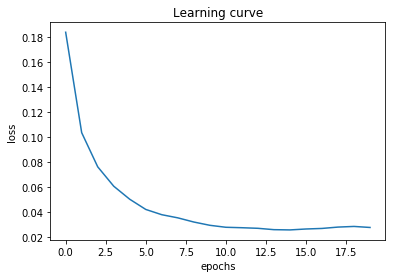

Stored 'y_pred' (ndarray)


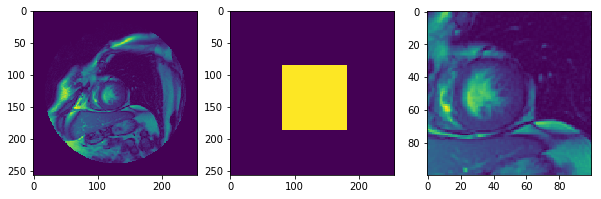

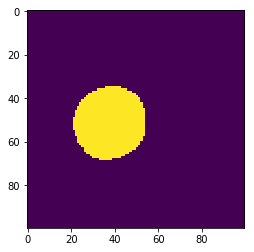

In [2]:
%run 'CNN.ipynb'

## Stacked auto-encoder

### 1rst part : another representation of the ROI with sparse auto-encoder

In [3]:
%store -r y_pred

In [4]:
input_AE = [] #images (100,100)
for j in range(y_pred.shape[0]):
    input_AE.append(cv2.resize(compute_roi_pred(y_pred, j, roi_shape=32)[0],(64 , 64)))
input_AE = np.asarray(input_AE).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

#### Model

In [5]:
from keras import losses
def customized_loss(y_true, y_pred):
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return 0.0001*0.5 * loss1 + 3 * loss2

In [6]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))

In [7]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_2 (None, 4096) (None, 100)
dense_3 (None, 100) (None, 4096)


#### Training

In [8]:
model.compile(loss= customized_loss,
              optimizer='adam')

In [9]:
h = model.fit(input_AE, input_AE, epochs=100, verbose=2)

Epoch 1/100
0s - loss: 64121.4479
Epoch 2/100
0s - loss: 13352.5192
Epoch 3/100
0s - loss: 8832.0252
Epoch 4/100
0s - loss: 8131.3821
Epoch 5/100
0s - loss: 7707.3785
Epoch 6/100
0s - loss: 7595.2495
Epoch 7/100
0s - loss: 7455.9135
Epoch 8/100
0s - loss: 7473.9253
Epoch 9/100
0s - loss: 7410.7210
Epoch 10/100
0s - loss: 7347.3310
Epoch 11/100
0s - loss: 7302.9944
Epoch 12/100
0s - loss: 7333.0282
Epoch 13/100
0s - loss: 7303.3939
Epoch 14/100
0s - loss: 7307.7655
Epoch 15/100
0s - loss: 7303.5896
Epoch 16/100
0s - loss: 7306.2344
Epoch 17/100
0s - loss: 7303.1910
Epoch 18/100
0s - loss: 7265.9611
Epoch 19/100
0s - loss: 7145.0386
Epoch 20/100
0s - loss: 7117.3974
Epoch 21/100
0s - loss: 7117.4548
Epoch 22/100
0s - loss: 7113.7798
Epoch 23/100
0s - loss: 7113.7858
Epoch 24/100
0s - loss: 7100.4368
Epoch 25/100
0s - loss: 6809.1850
Epoch 26/100
0s - loss: 6729.0069
Epoch 27/100
0s - loss: 6686.8075
Epoch 28/100
0s - loss: 6628.5290
Epoch 29/100
0s - loss: 6578.3695
Epoch 30/100
0s - los

Text(0.5,0,'epochs')

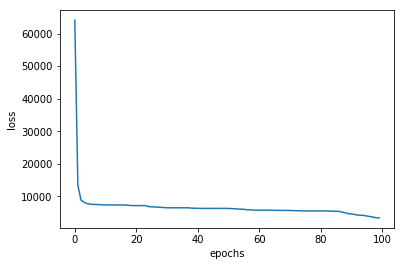

In [10]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

#### Prediction

In [11]:
input_AE_pred = model.predict(input_AE)

In [12]:
pred = input_AE_pred[0].reshape(64, 64)

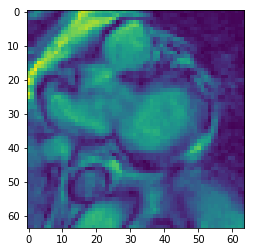

In [13]:
plt.imshow(input_AE[0].reshape(64,64))

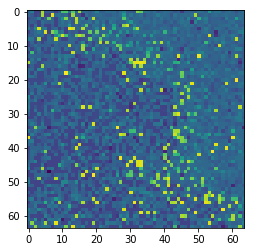

In [14]:
plt.imshow(pred)

### 2nd part : From new representation of ROI to inferred shape using annotated contours

In [15]:
_,_, mask_contour = compute_roi_pred(y_pred, 234)

In [16]:
contour_experts = [] #images (100,100)
for j in range(y_pred.shape[0]):
    contour_experts.append(cv2.resize(compute_roi_pred(y_pred, j)[2], (64,64), interpolation = cv2.INTERSECT_NONE))
contour_experts = np.asarray(contour_experts).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

In [17]:
input_y = contour_experts
input_x = input_AE#_pred

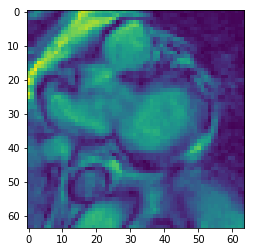

In [18]:
plt.imshow(input_AE[0].reshape(64,64))

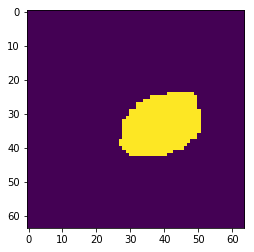

In [19]:
plt.imshow(contour_experts[0].reshape(64,64))

In [20]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001)))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))
#model.add(Dense(4096,  input_shape=[l2.shape[1]*l2.shape[2]]))
#model.add(Dense(100, input_shape=[l2.shape[1]]))

In [21]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_4 (None, 4096) (None, 100)
dense_5 (None, 100) (None, 100)
dense_6 (None, 100) (None, 4096)


In [22]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
h2 = model.fit(input_x, input_y, epochs=5, verbose=2, batch_size=1)

Epoch 1/5
13s - loss: 14.7515 - acc: 0.0000e+00
Epoch 2/5
11s - loss: 8.5147 - acc: 0.0000e+00
Epoch 3/5
11s - loss: 6.1898 - acc: 0.0000e+00
Epoch 4/5
10s - loss: 3.4703 - acc: 0.0000e+00
Epoch 5/5
10s - loss: 3.3448 - acc: 0.0000e+00


Text(0.5,0,'epochs')

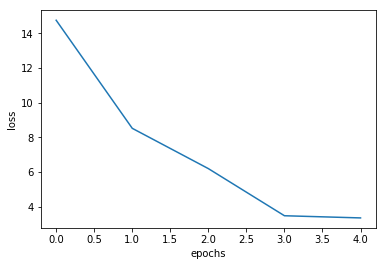

In [26]:
metric = 'loss'
plt.plot(range(len(h2.history[metric])), h2.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [27]:
l3_pred = model.predict(input_x)

In [28]:
pred3 = l3_pred[0].reshape(64, 64)

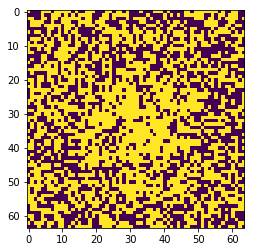

In [29]:
j = 17
# select one predicted ROI
pred3 = l3_pred[j].reshape((64,64))
p = cv2.threshold(pred3, 0, 1, cv2.THRESH_BINARY)
plt.imshow(p[1])

In [ ]:
pred3

In [ ]:
#pred3>0

2e stacked auto encoder ne fonctionne pas

In [ ]:
#opt_solution   = scipy.optimize.minimize(encoder1.sparseAutoencoderCost, encoder1.theta, 
#                                             args = (train_data,), method = 'L-BFGS-B', 
#                                             jac = True, options 